Logistic regression, using scikit-learn and statsmodels (based on introduction to statistical learning)

In [61]:
import numpy as np 
import pandas as pd
import math
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from ISLP.models import summarize
from ISLP import confusion_table
import seaborn as sns
from sklearn.metrics import RocCurveDisplay

In [2]:
#load datasets
large = pd.read_csv('../datasets/full_cleaned_dataset.csv')
small = pd.read_csv('../datasets/1std_dataset.csv')

In [3]:
#dropping unnesacary columns (z_score column, and index columns, and year))
small.drop(columns=['z_score', 'year'], inplace=True)
large.drop(columns=['Unnamed: 0', 'year'], inplace=True)

#drop any non-numeric colums from both datasets
#getting lists of numeric columns
numeric_columns = large.select_dtypes(include=np.number).columns

#dropping non-numeric columns from large and small datasets
large = large[numeric_columns]
small = small[numeric_columns]

#move the target (distressed) out of the dataset
large_target = large.pop('distressed')
small_target = small.pop('distressed')

#turn dfs in numpy arrays
nplarge = large.to_numpy()
npsmall = small.to_numpy()

In [4]:
# logistic regression
scaler = StandardScaler()
# standardize the features (mean 0, variance 1)
X = scaler.fit_transform(npsmall.copy())
y = small_target.copy()
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()

print(results.summary())

c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:             distressed   No. Observations:                  667
Model:                            GLM   Df Residuals:                      567
Model Family:                Binomial   Df Model:                           99
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 12 Apr 2025   Deviance:                   3.6244e-09
Time:                        10:27:30   Pearson chi2:                 1.81e-09
No. Iterations:                    30   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           326.1650   3.81e+06   8.57e-05      1.0

c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


The results if this first model are bad. The low R2 and all P-values being 1 indicated that Logistic regerssion might not be a good fit for our data.

There is a perfect spearation warning. This could be solved by using a different model (Firth logistic regression is usually recommended, but it's not part of the libraries I'm using). Another option would be to remove variables that are causing the bias. It difficult to figure out which variables are causing the bias.

There seem to be two issues with the data that must be solved:
1. The data is incredibly inbalanced. There are only a few distressed observations (8 out of 667). Doing some resampling (oversampling the distressed observations) might help. This can be achieved with SMOTE
2. The data seems to have multicollinearity. I should try to remove features that have high correlations, and build a new model based on the reduced dataset. This can be achieved by

In [5]:
#resampling using SMOTE
small_res, y_res = SMOTE().fit_resample(X, y)

print(f"Original dataset shape {Counter(y)}")
print(f"Resampled dataset shape {Counter(y_res)}")

Original dataset shape Counter({0.0: 659, 1.0: 8})
Resampled dataset shape Counter({0.0: 659, 1.0: 659})


We now have a 50/50 split in the data regarding distressed observations

In [6]:
glm = sm.GLM(y_res, small_res, family=sm.families.Binomial())
results = glm.fit()

print(results.summary())

c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


                 Generalized Linear Model Regression Results                  
Dep. Variable:             distressed   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1218
Model Family:                Binomial   Df Model:                           99
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 12 Apr 2025   Deviance:                       22105.
Time:                        10:27:32   Pearson chi2:                 1.08e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -2.09e+15    1.2e+08  -1.74e+07      0.0

c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


Simply adding more distressed observations to the dataset didn't help with the model. The underlying issues with colinearity still should be present, even if there is no error regarding that anymore.

To address that we can calculate the variance inflation factor (VIF) to find collinear features

In [7]:
# recreate a df with original features including the target variable
vif_small = small.copy()
vif_small['distressed'] = small_target.copy()

# calculate VIF for each feature
vals = [VIF(vif_small, i)
        for i in range(1, vif_small.shape[1])]
vif = pd.DataFrame({'vif': vals},
                   index=vif_small.columns[1:])
vif = vif.sort_values('vif', ascending=False)

vif = vif['vif'].round(3)

vif



c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


minorityInterest                           inf
totalLiabilitiesAndTotalEquity             inf
totalEquity                                inf
totalLiabilitiesAndStockholdersEquity      inf
totalStockholdersEquity                    inf
                                         ...  
deferredRevenueNonCurrent                4.130
weightedAverageShsOut                    2.924
deferredRevenue                          2.786
grossProfitRatio                         2.670
distressed                               2.071
Name: vif, Length: 103, dtype: float64

Looking at the VIF values, we can notice that some features end up with a VIF that converges into infinity. Those features can be removed from the dataset. (minorityInterest, totalLiabilitiesAndTotalEquity, totalEquity, totalLiabilitiesAndStockholdersEquity, totalStockholdersEquity, grossProfit, costOfRevenue, revenue)

There are some features with very high VIFs, but for now we'll check those again, after the infinite VIFs have been removed.

In [8]:
# removing the features with high VIF values
toremove = ['minorityInterest', 'totalLiabilitiesAndTotalEquity', 'totalEquity',
            'totalLiabilitiesAndStockholdersEquity', 'totalStockholdersEquity', 'grossProfit', 'costOfRevenue', 'revenue']

for i in toremove:
    if i in vif_small.columns:
        vif_small.drop(columns=[i], inplace=True)
    else:
        print(f"{i} not in columns")


In [9]:
# calcualte VIFs again
vals = [VIF(vif_small, i)
        for i in range(1, vif_small.shape[1])]
vif = pd.DataFrame({'vif': vals},
                   index=vif_small.columns[1:])

vif = vif.sort_values('vif', ascending=False)

vif = vif['vif'].round(3)

vif

eps                          3.621916e+10
epsdiluted                   3.621858e+10
cashAtEndOfPeriod            2.394800e+07
cashAtBeginningOfPeriod      1.665048e+07
operatingCashFlow            4.976434e+06
                                 ...     
deferredRevenueNonCurrent    3.891000e+00
weightedAverageShsOut        2.924000e+00
deferredRevenue              2.687000e+00
grossProfitRatio             2.619000e+00
distressed                   2.068000e+00
Name: vif, Length: 95, dtype: float64

There are still very high VIF values, but let's try to create a model with those features removed, to see if there are improvements.

In [10]:
#load and prepare dataset
small2 = pd.read_csv('../datasets/1std_dataset.csv')
small2.drop(columns=['z_score', 'year'], inplace=True)
small2.drop(columns=toremove, inplace=True)

#remove all non-numeric columns from the dataset
numeric_columns = small2.select_dtypes(include=np.number).columns
small2 = small2[numeric_columns]

# create y, the target variable and X, the features
X = small2.copy()
X.drop(columns=['distressed'], inplace=True)
y = small2.pop('distressed')

# create dummy variables using smote
X, y = SMOTE().fit_resample(X, y)

# run the logistic regression model
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()

print(results.summary())

c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


                 Generalized Linear Model Regression Results                  
Dep. Variable:             distressed   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1227
Model Family:                Binomial   Df Model:                           90
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 12 Apr 2025   Deviance:                       460.52
Time:                        10:27:45   Pearson chi2:                 2.25e+16
No. Iterations:                    28   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


Since the model is still very bad, let's try to remove all features with a VIF higher than 10. This will remove most of the features.

In [11]:
vals = [VIF(X, i)
        for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif': vals},
                   index=X.columns[1:])

vif.where(vif['vif'] > 10, inplace=True)
vif.dropna(inplace=True)
vif = vif.sort_values('vif', ascending=False)

toremove2 = list(vif.index)

In [12]:
#load and prepare dataset
small3 = pd.read_csv('../datasets/1std_dataset.csv')
small3.drop(columns=['z_score', 'year'], inplace=True)
small3.drop(columns=toremove, inplace=True)
small3.drop(columns=toremove2, inplace=True)

#remove all non-numeric columns from the dataset
numeric_columns = small3.select_dtypes(include=np.number).columns
small3 = small3[numeric_columns]

# create y, the target variable and X, the features
X = small3.copy()
X.drop(columns=['distressed'], inplace=True)
y = small3.pop('distressed')

# create dummy variables using smote
X, y = SMOTE().fit_resample(X, y)

# run the logistic regression model
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             distressed   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1311
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 12 Apr 2025   Deviance:                       1149.4
Time:                        10:27:50   Pearson chi2:                 9.94e+07
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
cashAndCashEquival

c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


We finally have a resemblence of a regular model.
We can standardize the data, and try to run the model again, this should give a better readable results.

In [13]:
# standardize the features (mean 0, variance 1)
X = scaler.fit_transform(X.copy())
y = y.copy()
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             distressed   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1311
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -592.20
Date:                Sat, 12 Apr 2025   Deviance:                       1184.4
Time:                        10:27:50   Pearson chi2:                 5.94e+08
No. Iterations:                    10   Pseudo R-squ. (CS):             0.3859
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.0221      0.248     12.189      0.0

R2 is 0.4 which is not that great. Considering how many features we dropped. I would suggest that logistic regression is simply not a good fit for the data we have at hand. But let's do some checks with the model, to get more insights.

In [ ]:
# do predictions
probs = results.predict(X)
probs[:10]

array([0.43968821, 0.89784463, 0.3731107 , 0.45116236, 0.01835094,
       0.02090706, 0.04089252, 0.0369803 , 0.40770469, 0.39706515])

In [ ]:
# create the labels based on the predicted probabilities
# 0 meaning not distressed, 1 meaning distressed, since that's how we trained the model
# thresholf u is set to 0.5
pred_labels = np.array(['0']*1318)
pred_labels[probs>0.5] = '1'

true_labels = y.round(decimals=0).astype(int).to_numpy().astype(str)

Now let's create the confusion matrix. It might be a little confusing, since 0,1 seem to be reversed. That is because we're asking whether the company is distressed or not, so a 1 means 'yes, the company is distressed'.

In [ ]:
confusion_table(pred_labels, true_labels)

Truth,0,1
Predicted,,
0,638,225
1,21,434


In [60]:
TP = 638
FP = 225
FN = 21
TN = 434

accuracy = (TP + TN) / (TP + FP + TN + FN)
missclassification_rate = (FP + FN) / (TP + FP + TN + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy}")
print(f"Missclassification rate: {missclassification_rate}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Accuracy: 0.8133535660091047
Missclassification rate: 0.18664643399089528
Sensitivity: 0.9681335356600911
Specificity: 0.6585735963581184


The result of the confusion matrix are pretty good, but there's a good chance that this is due to overfitting. (We're testing the model on the data we trained it on).
Specificity (true negative rate) is somewhat low, but this isn't a problem in our case. This simply means that companies, which are financially healthy get classified as distressed. Basically just being overly cautious. 

Let's create the ROC-curve to find the performance over the whole range of thresholds

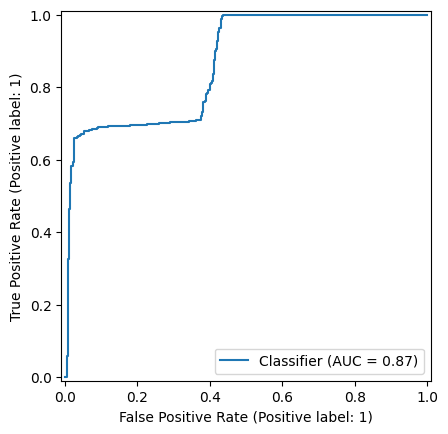

In [81]:
# ROC curve
roc_curve = RocCurveDisplay.from_predictions

roc_curve(true_labels, probs, pos_label='1')

An AUC 0.87 implies good performance. But this still might be due to overfitting.